In [1]:
import itertools
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.preprocessing import StandardScaler, RobustScaler
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False

# [단계 1]데이터 불러오기

In [3]:
file_path = '/Ford 엔진 진동 AI 데이터셋/dataset/'  # 사용자 Local 환경 내의 다운로드 받은 데이터 파일이 위치한 경로
train_fn="FordA_TRAIN.arff"  # Train 데이터 파일명
test_fn="FordA_TEST.arff"  # Test 데이터 파일명

def read_ariff(path):
    """
    .ariff 확장자를 Load하기 위한 함수
    """
    raw_data, meta = loadarff(path)
    cols = [x for x in meta]
    data2d = np.zeros([raw_data.shape[0],len(cols)])
    for i,col in zip(range(len(cols)),cols):
        data2d[:,i]=raw_data[col]
    return data2d

train = read_ariff(file_path + train_fn)
test = read_ariff(file_path + test_fn)

print("train_set.shape:", train.shape)
print("test_set.shape:", test.shape)

train_set.shape: (3601, 501)
test_set.shape: (1320, 501)


In [4]:
train=pd.DataFrame(train)
test=pd.DataFrame(test)

## 결측값 확인

In [153]:
(train.isnull().sum()!=0).sum()  #결측값 없음

0

In [154]:
(test.isnull().sum()!=0).sum()   #결측값 없음

0

## 기초통계

In [160]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
count,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,...,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000
mean,-0.016708,-0.015270,-0.013605,-0.011943,-0.009966,-0.007062,-0.003495,0.000568,0.005354,0.010032,...,0.006895,0.004053,0.000929,-0.001922,-0.003369,-0.003237,-0.001820,0.000031,0.001395,-0.025271
std,1.058455,1.051904,1.044560,1.042573,1.046933,1.052829,1.055439,1.054305,1.050424,1.044120,...,1.040632,1.040826,1.036657,1.028358,1.018719,1.011871,1.012367,1.020914,1.032490,0.999819
min,-3.933454,-3.656912,-3.479467,-3.595350,-3.773891,-3.914729,-3.855301,-4.497360,-4.552591,-4.000282,...,-4.073011,-4.014450,-3.817036,-3.574256,-3.746353,-3.680805,-3.904569,-4.221550,-4.076032,-1.000000
25%,-0.685693,-0.699526,-0.688302,-0.709732,-0.694991,-0.691035,-0.690316,-0.701244,-0.675094,-0.687749,...,-0.690143,-0.688232,-0.677701,-0.674282,-0.655946,-0.657258,-0.664392,-0.659578,-0.675838,-1.000000
50%,-0.007573,-0.003044,-0.003066,0.008598,0.001042,0.000280,-0.011988,-0.026672,-0.002031,0.010602,...,0.012348,0.003914,0.005957,-0.002728,-0.010841,-0.008002,-0.004802,-0.013723,-0.003186,-1.000000
75%,0.660360,0.674898,0.683698,0.679474,0.697530,0.688802,0.721442,0.705021,0.692256,0.689118,...,0.714817,0.707357,0.692837,0.666434,0.668463,0.671536,0.677346,0.684048,0.682921,1.000000
max,3.503936,3.369278,3.498286,3.493830,3.293318,3.605585,3.895870,3.741035,3.630933,3.579176,...,3.522197,3.842693,3.916653,3.670118,3.567879,3.471847,3.798079,3.863325,4.349744,1.000000


In [161]:
test.describe()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,...,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000
mean,0.056002,0.049911,0.038884,0.024069,0.007442,-0.008919,-0.023495,-0.033577,-0.038521,-0.040075,...,-0.020576,-0.021015,-0.022640,-0.024066,-0.024627,-0.023277,-0.019195,-0.012905,-0.004523,-0.031818
std,1.030455,1.027540,1.031559,1.037225,1.040995,1.041183,1.039772,1.037450,1.032377,1.023538,...,0.998892,1.003871,1.005505,1.001538,0.995777,0.995949,1.006263,1.021453,1.034000,0.999872
min,-3.295308,-3.114238,-3.143402,-3.210066,-3.488749,-3.297407,-3.530643,-3.614145,-3.499086,-3.891793,...,-2.759400,-2.923191,-3.345666,-3.640661,-3.644451,-3.323366,-3.675281,-4.136622,-4.339612,-1.000000
25%,-0.615181,-0.622534,-0.647919,-0.703829,-0.710411,-0.704157,-0.701900,-0.726534,-0.725647,-0.710225,...,-0.667106,-0.675032,-0.701321,-0.666676,-0.639500,-0.675741,-0.684490,-0.703068,-0.668710,-1.000000
50%,0.060755,0.063215,0.072926,0.046643,-0.001561,-0.033439,-0.069241,-0.038386,-0.039849,-0.054609,...,-0.025947,-0.018705,-0.023850,-0.047472,-0.059076,-0.055777,-0.062619,-0.038624,-0.010347,-1.000000
75%,0.725193,0.683444,0.708510,0.721956,0.711720,0.667813,0.662852,0.670717,0.656110,0.634353,...,0.645742,0.627622,0.626097,0.627942,0.618566,0.635043,0.610605,0.618785,0.642833,1.000000
max,3.972283,3.854763,3.500758,3.425150,3.603918,3.498317,3.202631,3.149192,3.149306,3.044482,...,3.038886,3.307455,3.440595,3.372724,3.878029,4.130681,4.099100,3.791179,3.696551,1.000000


# [단계 2] 데이터 시각화

## 데이터 균형/ 불균형 시각화

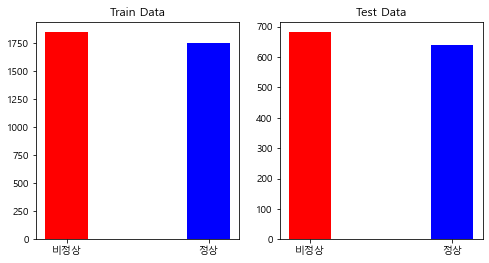

In [77]:
plt.figure(figsize=(8,4))  # Plot 틀(Figure)의 Size 설정 (5X3)

plt.subplot(1,2,1)
plt.title("Train Data")  # subplot 제목
x=[-1,1]
y=[(train.iloc[:,-1]==-1).sum(),(train.iloc[:,-1]==1).sum()]
plt.bar(x,y, width=0.6, color=["red", "blue"],label=x)  # Train 데이터의 정상/비정상 개수 BarPlot
plt.xticks([-1,1],['비정상','정상'])

plt.subplot(1,2,2)
plt.title("Test Data")  # subplot 제목
x=[-1,1]
y=[(test.iloc[:,-1]==-1).sum(),(test.iloc[:,-1]==1).sum()]
plt.bar(x,y, width=0.6, color=["red", "blue"],label=x)  # Train 데이터의 정상/비정상 개수 BarPlot
plt.xticks([-1,1],['비정상','정상'])

plt.show()   #균형적으로 분포 

## 1개의 임의의 센서 시계열 플롯 (정상/비정상 샘플 각각 출력)

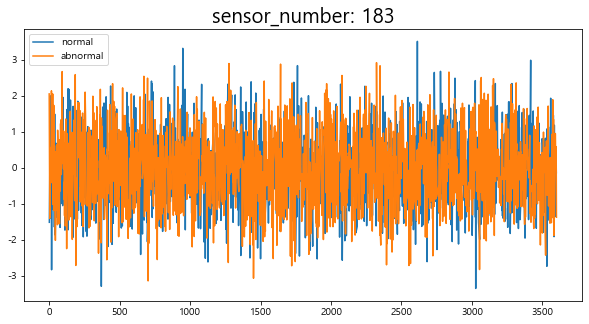

In [152]:
import random

plt.figure(figsize=(10, 5))     

sensor_number = random.randint(0, 500) 
y1=train[train.iloc[:,-1]==1][[sensor_number]]
y2=train[train.iloc[:,-1]==-1][[sensor_number]]
plt.plot(y1.index,y1,label = 'normal')  #정상
plt.plot(y2.index,y2,label = 'abnormal')  #비정상

plt.title("sensor_number: {}".format(sensor_number), fontsize=20)
plt.legend()  
plt.show()

## 400개 묶음으로 정상/비정상 비중 판단 

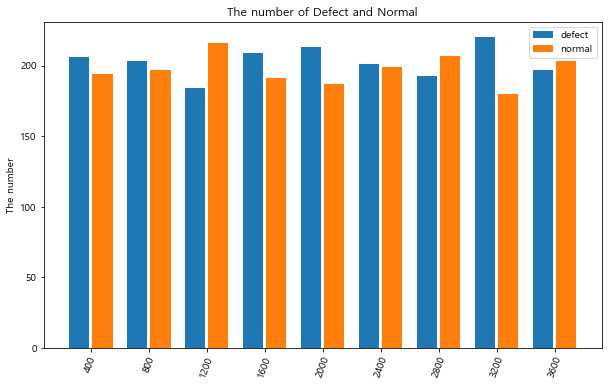

In [261]:
fig = plt.figure(figsize=(10, 6))
N = 9
d = (206,203,184,209,213,201,193,220,197) 
n=(194,197,216,191,187,199,207,180,203)

ind = np.arange(N) 
width = 0.35 
p1 = plt.bar(ind-0.2, d, width) 
p2 = plt.bar(ind+0.2, n, width) 
plt.ylabel('The number') 
plt.title('The number of Defect and Normal') 
plt.xticks(ind, (  '400',  '800', '1200', '1600', '2000', '2400', '2800','3200','3600'),rotation=70) 
plt.legend((p1[0], p2[0]), ('defect', 'normal')) 
plt.show()

# [단계 3] 데이터 특성 파악

## 상관관계 분석

In [166]:
train.iloc[:,:-1].corr()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,0.955441,0.824725,0.624149,0.384718,0.141105,-0.081436,-0.269796,-0.419172,-0.531380,...,-0.011001,-0.015618,-0.019913,-0.023282,-0.024699,-0.023207,-0.018717,-0.011458,-0.002540,0.006706
1,0.955441,1.000000,0.953253,0.817840,0.615756,0.380432,0.142303,-0.077788,-0.266956,-0.420095,...,-0.007372,-0.012603,-0.017161,-0.020554,-0.022192,-0.021397,-0.018186,-0.012603,-0.005416,0.002471
2,0.824725,0.953253,1.000000,0.951913,0.816276,0.618187,0.387548,0.150078,-0.073239,-0.267894,...,-0.003996,-0.008995,-0.013026,-0.015697,-0.016976,-0.016548,-0.014561,-0.010909,-0.006001,-0.000217
3,0.624149,0.817840,0.951913,1.000000,0.952416,0.820269,0.626396,0.396051,0.155091,-0.073066,...,-0.001879,-0.005665,-0.008267,-0.009394,-0.009632,-0.009112,-0.008102,-0.006411,-0.004099,-0.000983
4,0.384718,0.615756,0.816276,0.952416,1.000000,0.953921,0.824793,0.631320,0.398501,0.154771,...,-0.001041,-0.002897,-0.003520,-0.002723,-0.001623,-0.000769,-0.000478,-0.000517,-0.000659,-0.000249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.023207,-0.021397,-0.016548,-0.009112,-0.000769,0.006880,0.012462,0.014795,0.013418,0.008858,...,0.139157,0.382867,0.618059,0.816540,0.951438,1.000000,0.949709,0.805745,0.593625,0.350923
496,-0.018717,-0.018186,-0.014561,-0.008102,-0.000478,0.006716,0.012059,0.014294,0.013025,0.008671,...,-0.093927,0.131131,0.373025,0.608567,0.810641,0.949709,1.000000,0.948890,0.805932,0.600453
497,-0.011458,-0.012603,-0.010909,-0.006411,-0.000517,0.005334,0.009759,0.011494,0.010203,0.006105,...,-0.291613,-0.103124,0.118639,0.359530,0.598322,0.805745,0.948890,1.000000,0.949883,0.812772
498,-0.002540,-0.005416,-0.006001,-0.004099,-0.000659,0.003181,0.006184,0.007151,0.005758,0.001965,...,-0.443286,-0.298707,-0.114149,0.105857,0.349404,0.593625,0.805932,0.949883,1.000000,0.952489


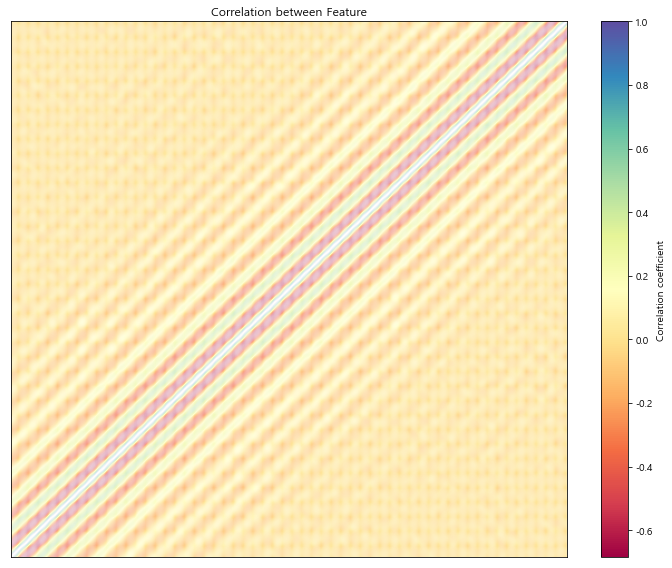

In [165]:
import matplotlib.cm as cm
from matplotlib.collections import EllipseCollection

data = train.iloc[:,:-1].corr()

def plot_corr_ellipses(data, ax =None, **kwargs):

    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap = cm.get_cmap('Spectral')
m = plot_corr_ellipses(data, ax=ax, cmap=cmap)
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')
# ax.margins(0.1)

plt.title('Correlation between Feature')
# labels = label
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()
#plt.savefig(save_path + 'corr.png', dpi=100, bbox_inches='tight')  # 그림 저장

plt.show()

## 주성분분석

In [219]:
from sklearn.decomposition import PCA   #주성분분석 

pca = PCA()
pca.fit(train.iloc[:,:-1])
PC_score = pca.transform(train.iloc[:,:-1])
#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환

,V_ration
PC1,0.087289
PC2,0.085017
PC3,0.065960
PC4,0.064637
PC5,0.049732
PC6,0.047868


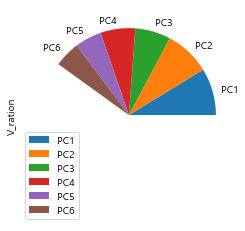

In [222]:
ratio = pca.explained_variance_ratio_[:6]
df_v = pd.DataFrame(ratio, index=['PC1','PC2','PC3','PC4','PC5','PC6'], columns=['V_ration'])
df_v.plot.pie(y='V_ration')
df_v   #주성분 분석을 해도 설명력이 낮아 의미 없음 

# [단계 4] 데이터 전처리

## 데이터 분리

In [5]:
# y값 변경

train[500][train[500] == -1] = 0
test[500][test[500] == -1] = 0

In [6]:
x_train = train[train.columns.difference([500])] 
y_train = train[[500]]

x_test = test[test.columns.difference([500])] 
y_test = test[[500]]

print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

x_train.shape: (3601, 500)
x_test.shape: (1320, 500)
y_train.shape: (3601, 1)
y_test.shape: (1320, 1)


## 데이터 정규화

StandardScalar는 데이터를 단위 분산으로 조정함으로써 Outlier에 취약할 수 있는 반면,     
RobustScaler는 Feature 간 같은 스케일을 갖게 되지만 평균과 분산 대신 중간 값(median)과 사분위값(quartile)을 사용함으로써,    
극단값(Outlier)에 영향을 받지 않음

In [7]:
from sklearn.preprocessing import RobustScaler

rscaler = RobustScaler() 

rscaler.fit(x_train)

x_train_scaled = rscaler.transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled) 

x_test_scaled = rscaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled) 

In [56]:
x_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,132

In [57]:
x_test_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,132

# [단계 5] 모델 구축 및 훈련

In [12]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix 

from sklearn.feature_selection import SelectFromModel    

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. 랜덤 포레스트

In [8]:
rf_params = {'n_estimators':[100, 500],'max_depth' : [4,6,8,10], 'min_samples_leaf' : [4, 8, 12, 16]}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0)
rf_grid = GridSearchCV(rf_clf , param_grid=rf_params , refit=True )
rf_grid.fit(x_train_scaled, y_train)

print('GridSearchCV 최적 파라미터:', rf_grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(rf_grid.best_score_))

GridSearchCV 최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 500}
GridSearchCV 최고 정확도: 0.7584


In [58]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
rf_estimator = rf_grid.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = rf_estimator.predict(x_test_scaled)

print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

테스트 데이터 세트 정확도: 0.7591
[[547 134]
 [184 455]]


In [59]:
p = precision_score(y_test, pred)
print("precision: %0.4f" %p)
r = recall_score(y_test, pred)
print("recall: %0.4f" %r)
f1 = f1_score(y_test, pred)
print("f1-score: %0.4f" %f1)

precision: 0.7725
recall: 0.7121
f1-score: 0.7410


In [1]:
# result = pd.Series(rf_estimator.feature_importances_, index=x_train_scaled.columns )

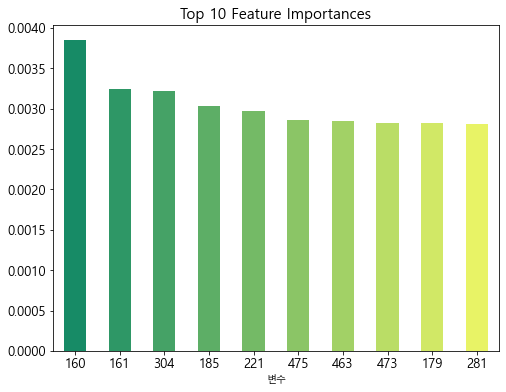

In [61]:
ftr_importances = pd.Series(rf_estimator.feature_importances_, index=x_train_scaled.columns )
ftr_top = ftr_importances.sort_values(ascending=False)[:10]

colors = sns.color_palette('summer', 10)
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances',size=15)
ftr_top.plot.bar(color=colors)
plt.xlabel('변수')
plt.xticks(rotation=0,size=13)
plt.yticks(size=13)
plt.show()

### 모델 기반 특성 선택 - 랜덤포레스트

In [15]:
%%time

select = SelectFromModel(
         RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_leaf=4, random_state=42),
         threshold="mean")
select.fit(x_train_scaled,y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=10,
                                                 min_samples_leaf=4,
                                                 n_estimators=500,
                                                 random_state=42),
                threshold='mean')

In [16]:
lt = list([select.get_support()])
lt = pd.DataFrame(lt,columns=x_train_scaled.columns)
pd.set_option('display.max_columns',None)
lt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,True,True,False,True,True,False,False,False,False,False,True,False,True,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,True,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,False,True,True,True,True,True,False,False,False,True,True,True,False,True,True,False,False,False,True,False,False,False,True,True,True,False,True,True,False,False,False,False,True,True,True,False,True,False,True,True,True,True,False,True,True,False,True,True,True,True,False,True,False,True,True,False,False,True,True,False,True,False,True,False,False,False,False,False,False,False,True,False,True,False,True,False,True,True,False,False,False,True,False,False,False,False,True,True,True,True,True,False,False,True,True,False,True,True,True,True,True,True,False,False,True,False,True,True,False,False,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,False,False,True,True,True,True,True,True,False,True,True,False,False,False,False,True,False,True,False,True,False,True,False,True,True,False,True,True,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,True,False,False,False,True,False,True,True,True,True,True,True,True,True,False,False,True,False,False,True,True,True,False,True,Fa

In [17]:
lt.T.loc[lt.T[0]==True,:]   #선택된 변수 

,0
0,True
1,True
3,True
4,True
10,True
...,...
495,True
496,True
497,True
498,True


In [18]:
x_train_rf_select = select.transform(x_train_scaled)
x_train_rf_select = pd.DataFrame(x_train_rf_select, columns=lt.T.loc[lt.T[0]==True,:].index) 

print("x_train_scaled.shape:", x_train_scaled.shape)
print("x_train_rf_select.shape:", x_train_rf_select.shape)

x_train_scaled.shape: (3601, 500)
x_train_rf_select.shape: (3601, 237)


In [19]:
x_test_rf_select = select.transform(x_test_scaled)
x_test_rf_select = pd.DataFrame(x_test_rf_select, columns=lt.T.loc[lt.T[0]==True,:].index) 

print("x_test_scaled.shape:", x_test_scaled.shape)
print("x_test_rf_select.shape:", x_test_rf_select.shape)

x_test_scaled.shape: (1320, 500)
x_test_rf_select.shape: (1320, 237)


### 선택된 변수로 모형 구축 - 랜덤포레스트

In [20]:
%%time

rf_params = {'n_estimators':[100, 500],'max_depth' : [4,6,8,10], 'min_samples_leaf' : [4, 8, 12, 16]}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0)
rf_grid = GridSearchCV(rf_clf , param_grid=rf_params , refit=True )
rf_grid.fit(x_train_rf_select, y_train)

print('GridSearchCV 최적 파라미터:', rf_grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(rf_grid.best_score_))

GridSearchCV 최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 500}
GridSearchCV 최고 정확도: 0.7495
Wall time: 20min 23s


In [21]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
rf_estimator = rf_grid.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = rf_estimator.predict(x_test_rf_select)

print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

테스트 데이터 세트 정확도: 0.7280
[[523 158]
 [201 438]]


In [22]:
p = precision_score(y_test, pred)
print("precision: %0.4f" %p)
r = recall_score(y_test, pred)
print("recall: %0.4f" %r)
f1 = f1_score(y_test, pred)
print("f1-score: %0.4f" %f1)

precision: 0.7349
recall: 0.6854
f1-score: 0.7093


In [2]:
# result = pd.Series(rf_estimator.feature_importances_, index=x_train_rf_select.columns )
# print("변수의 중요도:\n",result.sort_values(ascending=False))

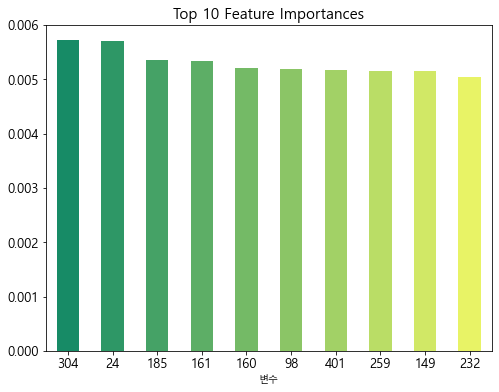

In [24]:
ftr_importances = pd.Series(rf_estimator.feature_importances_, index=x_train_rf_select.columns )
ftr_top = ftr_importances.sort_values(ascending=False)[:10]

colors = sns.color_palette('summer', 10)
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances',size=15)
ftr_top.plot.bar(color=colors)
plt.xlabel('변수')
plt.xticks(rotation=0,size=13)
plt.yticks(size=13)
plt.show()

## 2. LGBM

In [27]:
%%time

lgbm_params = {'n_estimators':[500], 'max_depth': [6, 8, 10], 'learning_rate':[0.05, 0.01],
               'reg_lambda' : [0,0.1,1,2]}

lgbm = LGBMClassifier(objective='binary',random_state=0)
lgbm_grid = GridSearchCV(lgbm , param_grid=lgbm_params, refit=True )
lgbm_grid.fit(x_train_scaled, y_train)
        
print('GridSearchCV 최적 파라미터:', lgbm_grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(lgbm_grid.best_score_))

GridSearchCV 최적 파라미터: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'reg_lambda': 1}
GridSearchCV 최고 정확도: 0.8078
Wall time: 29min 56s


In [28]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
lgbm_estimator = lgbm_grid.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = lgbm_estimator.predict(x_test_scaled)

print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

테스트 데이터 세트 정확도: 0.8174
[[572 109]
 [132 507]]


In [29]:
p = precision_score(y_test, pred)
print("precision: %0.4f" %p)
r = recall_score(y_test, pred)
print("recall: %0.4f" %r)
f1 = f1_score(y_test, pred)
print("f1-score: %0.4f" %f1)

precision: 0.8231
recall: 0.7934
f1-score: 0.8080


In [3]:
# result = pd.Series(data=np.round(lgbm_estimator.feature_importances_, 1), index=x_train_scaled.columns )
# print("변수의 중요도:\n",result.sort_values(ascending=False))

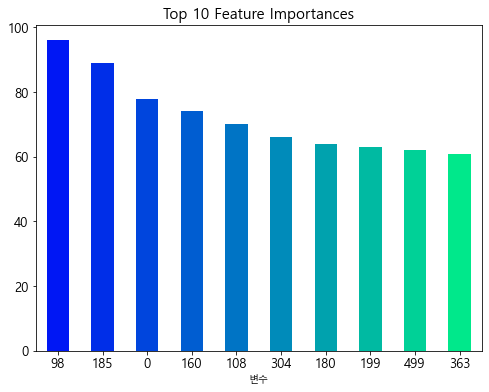

In [31]:
ftr_importances = pd.Series(lgbm_estimator.feature_importances_, index=x_train_scaled.columns )
ftr_top = ftr_importances.sort_values(ascending=False)[:10]

colors = sns.color_palette('winter', 10)
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances',size=15)
ftr_top.plot.bar(color=colors)
plt.xlabel('변수')
plt.xticks(rotation=0,size=13)
plt.yticks(size=13)
plt.show()

### 모델 기반 특성 선택 - LGBM

In [32]:
%%time

select = SelectFromModel(
         LGBMClassifier(objective='binary',n_estimators=500, max_depth=10,learning_rate=0.05,reg_lambda=1, random_state=42),
         threshold="mean")
select.fit(x_train_scaled,y_train)

Wall time: 20.7 s


SelectFromModel(estimator=LGBMClassifier(learning_rate=0.05, max_depth=10,
                                         n_estimators=500, objective='binary',
                                         random_state=42, reg_lambda=1),
                threshold='mean')

In [33]:
lt = list([select.get_support()])
lt = pd.DataFrame(lt,columns=x_train_scaled.columns)
pd.set_option('display.max_columns',None)
lt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,False,True,False,True,False,True,False,True,True,True,True,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,False,True,True,False,False,True,True,True,True,False,True,False,False,True,True,False,False,False,False,True,True,True,False,True,False,True,True,False,False,False,True,True,True,True,True,True,True,False,False,False,False,True,True,False,True,True,False,False,False,False,False,False,True,False,True,True,False,True,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,True,True,True,True,True,True,False,False,False,False,True,False,True,True,False,True,False,True,False,True,False,True,True,True,False,False,False,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,False,False,False,True,True,False,False,False,False,True,False,False,True,True,True,True,False,False,False,True,True,True,False,True,True,True,True,False,True,True,True,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,True,False,True,True,True,False,True,False,False,False,False,True,True,True,True,False,False,True,True,True,False,False,False,False,False,False,False,True,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,True,True,True,False,True,True,False,False,False,False,True,True,True,False,False,False,True,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,True,False,True,False,False,True,True,True,False,True,False,True,True,True,False,False,False,False,True,True,True,False,False,False,True,F

In [34]:
lt.T.loc[lt.T[0]==True,:]   #선택된 변수 

,0
0,True
1,True
2,True
3,True
4,True
...,...
490,True
495,True
496,True
498,True


In [35]:
x_train_lg_select = select.transform(x_train_scaled)
x_train_lg_select = pd.DataFrame(x_train_lg_select, columns=lt.T.loc[lt.T[0]==True,:].index) 

print("x_train_scaled.shape:", x_train_scaled.shape)
print("x_train_lg_select.shape:", x_train_lg_select.shape)

x_train_scaled.shape: (3601, 500)
x_train_lg_select.shape: (3601, 220)


In [36]:
x_test_lg_select = select.transform(x_test_scaled)
x_test_lg_select = pd.DataFrame(x_test_lg_select, columns=lt.T.loc[lt.T[0]==True,:].index) 

print("x_test_scaled.shape:", x_test_scaled.shape)
print("x_test_lg_select.shape:", x_test_lg_select.shape)

x_test_scaled.shape: (1320, 500)
x_test_lg_select.shape: (1320, 220)


### 선택된 변수로 모형 구축 -  LGBM

In [37]:
%%time
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

lgbm_params = {'n_estimators':[500], 'max_depth': [6, 8, 10], 'learning_rate':[0.05, 0.01],
               'reg_lambda' : [0,0.1,1,2]}  #'reg_alpha': [0,0.1,1, 2, 6]


lgbm = LGBMClassifier(objective='binary',random_state=0)
lgbm_grid = GridSearchCV(lgbm , param_grid=lgbm_params, refit=True )
lgbm_grid.fit(x_train_lg_select, y_train)
        
print('GridSearchCV 최적 파라미터:', lgbm_grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(lgbm_grid.best_score_))

GridSearchCV 최적 파라미터: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'reg_lambda': 2}
GridSearchCV 최고 정확도: 0.8089
Wall time: 12min 34s


In [38]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
lgbm_estimator = lgbm_grid.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = lgbm_estimator.predict(x_test_lg_select)

print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

테스트 데이터 세트 정확도: 0.7977
[[560 121]
 [146 493]]


In [39]:
p = precision_score(y_test, pred)
print("precision: %0.4f" %p)
r = recall_score(y_test, pred)
print("recall: %0.4f" %r)
f1 = f1_score(y_test, pred)
print("f1-score: %0.4f" %f1)

precision: 0.8029
recall: 0.7715
f1-score: 0.7869


In [4]:
# result = pd.Series(data=np.round(lgbm_estimator.feature_importances_, 1), index=x_train_lg_select.columns )
# print("변수의 중요도:\n",result.sort_values(ascending=False))

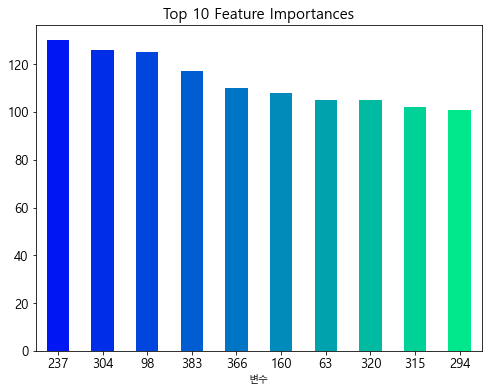

In [41]:
ftr_importances = pd.Series(lgbm_estimator.feature_importances_, index=x_train_lg_select.columns )
ftr_top = ftr_importances.sort_values(ascending=False)[:10]

colors = sns.color_palette('winter', 10)
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances',size=15)
ftr_top.plot.bar(color=colors)
plt.xlabel('변수')
plt.xticks(rotation=0,size=13)
plt.yticks(size=13)
plt.show()

## 3. XGBoost

In [198]:
%%time
from xgboost import XGBClassifier

xgb_params = {'n_estimators':[500], 'max_depth': [6, 8, 10], 'learning_rate':[0.05, 0.01],
               'lambda' : [1,2,4],'objective':['binary:logistic'],'eval_metric':['error']}
 
xgb_clf = XGBClassifier(random_state=0)  
xgb_grid = GridSearchCV(xgb_clf, param_grid=xgb_params, refit=True )
xgb_grid.fit(x_train_scaled, y_train)
        
print('GridSearchCV 최적 파라미터:', xgb_grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(xgb_grid.best_score_))

GridSearchCV 최적 파라미터: {'eval_metric': 'error', 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'objective': 'binary:logistic'}
GridSearchCV 최고 정확도: 0.7981
Wall time: 4h 47min 49s


In [199]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
xgb_estimator = xgb_grid.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = xgb_estimator.predict(x_test_scaled)

print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

테스트 데이터 세트 정확도: 0.8068
[[562 119]
 [136 503]]


In [200]:
p = precision_score(y_test, pred)
print("precision: %0.4f" %p)
r = recall_score(y_test, pred)
print("recall: %0.4f" %r)
f1 = f1_score(y_test, pred)
print("f1-score: %0.4f" %f1)

precision: 0.8087
recall: 0.7872
f1-score: 0.7978


In [5]:
# result = pd.Series(data=np.round(xgb_estimator.feature_importances_, 1), index=x_train_scaled.columns )
# print("변수의 중요도:\n",result.sort_values(ascending=False))

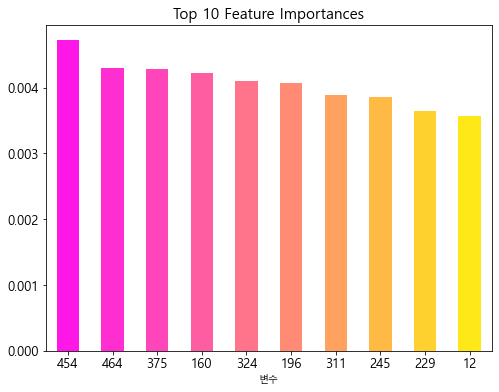

In [202]:
ftr_importances = pd.Series(xgb_estimator.feature_importances_, index=x_train_scaled.columns )
ftr_top = ftr_importances.sort_values(ascending=False)[:10]

colors = sns.color_palette('spring', 10)
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances',size=15)
ftr_top.plot.bar(color=colors)
plt.xlabel('변수')
plt.xticks(rotation=0,size=13)
plt.yticks(size=13)
plt.show()

### 모델 기반 특성 선택 - XGBoost

In [204]:
%%time

select = SelectFromModel(
         XGBClassifier(eval_metric='error', learning_rate=0.05,
                        max_depth=10, n_estimators=500, objective='binary:logistic'),
         threshold="mean")
select.fit(x_train_scaled,y_train)

Wall time: 2min 51s


SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        eval_metric='error', gamma=None,
                                        gpu_id=None, importance_type='gain',
                                        interaction_constraints=None,
                                        learning_rate=0.05, max_delta_step=None,
                                        max_depth=10, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=500, n_jobs=None,
                                        num_parallel_tree=None,
                                        random_state=None, reg_alpha=None,
                                        reg_lambda=None, scale_pos_weig

In [205]:
lt = list([select.get_support()])
lt = pd.DataFrame(lt,columns=x_train_scaled.columns)
pd.set_option('display.max_columns',None)
lt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,True,False,True,False,True,False,False,True,False,True,True,True,True,False,True,True,False,False,False,False,False,True,True,True,True,False,False,False,False,False,True,True,False,False,True,False,False,True,True,False,False,False,False,False,False,False,True,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,True,False,True,True,True,False,True,False,True,True,True,True,False,False,False,True,False,False,True,False,False,False,True,True,False,True,True,False,False,True,True,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,True,True,False,True,False,False,False,False,True,False,False,True,True,False,False,False,True,True,True,False,False,False,True,True,True,True,True,True,True,True,True,True,False,True,False,False,False,False,True,False,False,True,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True,True,False,True,False,True,True,False,False,True,True,False,True,False,False,False,False,True,True,True,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,True,True,False,False,True,False,False,True,False,True,True,False,True,True,True,True,True,False,True,True,False,True,True,False,False,True,False,True,False,True,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,True,True,False,True,True,True,False,True,False,False,True,True,False,False,True,True,True,True,False,True,True,True,False,False,True,True,True,True,True,False,False,True,True,True,True,False,False,True,True,False,False,False,False,False,True,True,True,False,True,False,True,True,True,True,False,False,True,False,True,True,True,True,True,False,False,True,False,False,False,False,False,True,True,True,False,False,True,True,False,False,False,True,False,False,False,True,True,False,True,Fals

In [206]:
lt.T.loc[lt.T[0]==True,:]   #선택된 변수 

,0
0,True
2,True
4,True
7,True
9,True
...,...
494,True
495,True
497,True
498,True


In [207]:
x_train_xgb_select = select.transform(x_train_scaled)
x_train_xgb_select = pd.DataFrame(x_train_xgb_select, columns=lt.T.loc[lt.T[0]==True,:].index) 

print("x_train_scaled.shape:", x_train_scaled.shape)
print("x_train_xgb_select.shape:", x_train_xgb_select.shape)

x_train_scaled.shape: (3601, 500)
x_train_xgb_select.shape: (3601, 226)


In [208]:
x_test_xgb_select = select.transform(x_test_scaled)
x_test_xgb_select = pd.DataFrame(x_test_xgb_select, columns=lt.T.loc[lt.T[0]==True,:].index) 

print("x_test_scaled.shape:", x_test_scaled.shape)
print("x_test_xgb_select.shape:", x_test_xgb_select.shape)

x_test_scaled.shape: (1320, 500)
x_test_xgb_select.shape: (1320, 226)


### 선택된 변수로 모형 구축 -  XGBoost

In [211]:
%%time
from xgboost import XGBClassifier

xgb_params = {'n_estimators':[500], 'max_depth': [6, 8, 10], 'learning_rate':[0.05, 0.01],
              'objective':['binary:logistic'],'eval_metric':['error']}
 
xgb_clf = XGBClassifier(random_state=0)  
xgb_grid = GridSearchCV(xgb_clf, param_grid=xgb_params,n_jobs=-1, refit=True )
xgb_grid.fit(x_train_xgb_select, y_train)
        
print('GridSearchCV 최적 파라미터:', xgb_grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(xgb_grid.best_score_))

GridSearchCV 최적 파라미터: {'eval_metric': 'error', 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'objective': 'binary:logistic'}
GridSearchCV 최고 정확도: 0.7853
Wall time: 30min 6s


In [212]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
xgb_estimator = xgb_grid.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = xgb_estimator.predict(x_test_xgb_select)

print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

테스트 데이터 세트 정확도: 0.7970
[[546 135]
 [133 506]]


In [213]:
p = precision_score(y_test, pred)
print("precision: %0.4f" %p)
r = recall_score(y_test, pred)
print("recall: %0.4f" %r)
f1 = f1_score(y_test, pred)
print("f1-score: %0.4f" %f1)

precision: 0.7894
recall: 0.7919
f1-score: 0.7906


In [6]:
# result = pd.Series(data=np.round(xgb_estimator.feature_importances_, 1), index=x_train_xgb_select.columns )
# print("변수의 중요도:\n",result.sort_values(ascending=False))

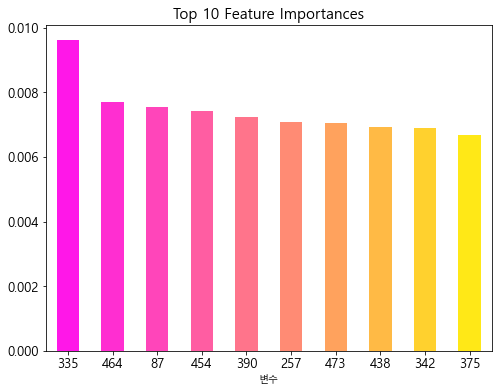

In [215]:
ftr_importances = pd.Series(xgb_estimator.feature_importances_, index=x_train_xgb_select.columns )
ftr_top = ftr_importances.sort_values(ascending=False)[:10]

colors = sns.color_palette('spring', 10)
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances',size=15)
ftr_top.plot.bar(color=colors)
plt.xlabel('변수')
plt.xticks(rotation=0,size=13)
plt.yticks(size=13)
plt.show()

## 4. 로지스틱 회귀

In [42]:
%%time

lr_params={'penalty':['l2', 'l1'],'tol':[0.0001,0.001,0.01], 'C':[0.01, 0.1, 1, 1, 5, 10]}

lr_clf = LogisticRegression(random_state=0)
lr_grid = GridSearchCV(lr_clf, param_grid=lr_params, scoring='accuracy', refit=True )
lr_grid.fit(x_train_scaled,y_train)

print('GridSearchCV 최적 파라미터:', lr_grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(lr_grid.best_score_))

GridSearchCV 최적 파라미터: {'C': 0.01, 'penalty': 'l2', 'tol': 0.0001}
GridSearchCV 최고 정확도: 0.5026
Wall time: 22.2 s


In [66]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
lr_estimator = lr_grid.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = lr_estimator.predict(x_test_scaled)

print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

테스트 데이터 세트 정확도: 0.4848
[[363 318]
 [362 277]]


In [67]:
p = precision_score(y_test, pred)
print("precision: %0.4f" %p)
r = recall_score(y_test, pred)
print("recall: %0.4f" %r)
f1 = f1_score(y_test, pred)
print("f1-score: %0.4f" %f1)

precision: 0.4655
recall: 0.4335
f1-score: 0.4489


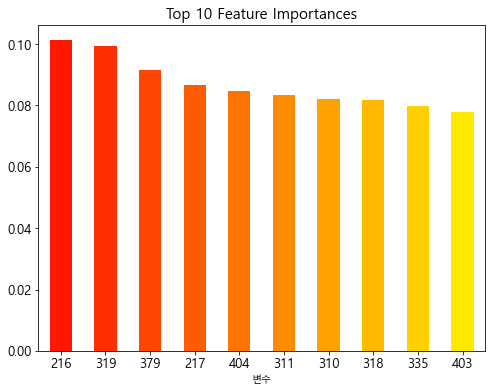

In [68]:
coef = pd.DataFrame(lr_estimator.coef_, columns=x_train_scaled.columns)
coef_sort = coef.iloc[0,].sort_values(ascending=False)[:10]

colors = sns.color_palette('autumn', 10)
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances',size=15)
coef_sort.plot.bar(color=colors)
plt.xlabel('변수')
plt.xticks(rotation=0,size=13)
plt.yticks(size=13)
plt.show()

### 모델 기반 특성 선택 - 로지스틱

In [45]:
%%time

select = SelectFromModel(
         LogisticRegression(C=0.01, penalty='l2', tol=0.0001,random_state=42),
         threshold="mean")
select.fit(x_train_scaled,y_train)

Wall time: 153 ms


SelectFromModel(estimator=LogisticRegression(C=0.01, random_state=42),
                threshold='mean')

In [46]:
lt = list([select.get_support()])
lt = pd.DataFrame(lt,columns=x_train_scaled.columns)
pd.set_option('display.max_columns',None)
lt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,False,False,False,False,True,False,False,False,True,False,False,False,True,True,True,True,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,True,True,False,False,True,True,True,False,False,True,True,True,True,False,False,True,True,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,False,False,True,True,False,False,True,True,False,False,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,True,True,False,False,True,True,True,True,True,False,False,False,False,True,True,False,False,True,True,True,True,False,True,True,True,False,False,True,True,True,False,False,False,False,False,True,True,False,False,True,True,True,False,False,False,False,False,True,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True,False,False,True,True,False,False,False,True,True,True,False,True,True,True,True,False,True,True,True,True,True,False,False,True,True,True,False,False,False,False,True,True,True,True,False,False,True,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,False,False,False,False,False,True,True,True,False,False,True,True,False,True,True,True,True,True,False,True,True,True,False,True,True,False,False,True,True,True,True,False,True,True,False,False,True,True,True,True,False,True,True,True,False,True,True,True,True,True,False,True,True,True,False,True,True,True,False,True,True

In [47]:
lt.T.loc[lt.T[0]==True,:]   #선택된 변수 

,0
4,True
8,True
12,True
13,True
14,True
...,...
494,True
495,True
496,True
497,True


In [48]:
x_train_lr_select = select.transform(x_train_scaled)
x_train_lr_select = pd.DataFrame(x_train_lr_select, columns=lt.T.loc[lt.T[0]==True,:].index) 

print("x_train_scaled.shape:", x_train_scaled.shape)
print("x_train_lr_select.shape:", x_train_lr_select.shape)

x_train_scaled.shape: (3601, 500)
x_train_lr_select.shape: (3601, 228)


In [49]:
x_test_lr_select = select.transform(x_test_scaled)
x_test_lr_select = pd.DataFrame(x_test_lr_select, columns=lt.T.loc[lt.T[0]==True,:].index) 

print("x_test_scaled.shape:", x_test_scaled.shape)
print("x_test_lr_select.shape:", x_test_lr_select.shape)

x_test_scaled.shape: (1320, 500)
x_test_lr_select.shape: (1320, 228)


### 선택된 변수로 모형 구축 - 로지스틱

In [50]:
%%time

lr_params={'penalty':['l2', 'l1'],'tol':[0.0001,0.001,0.01], 'C':[0.01, 0.1, 1, 1, 5, 10]}

lr_clf = LogisticRegression(random_state=0)
lr_grid = GridSearchCV(lr_clf, param_grid=lr_params, scoring='accuracy', refit=True )
lr_grid.fit(x_train_lr_select,y_train)

print('GridSearchCV 최적 파라미터:', lr_grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(lr_grid.best_score_))

GridSearchCV 최적 파라미터: {'C': 0.01, 'penalty': 'l2', 'tol': 0.0001}
GridSearchCV 최고 정확도: 0.5126
Wall time: 14.4 s


In [51]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
lr_estimator = lr_grid.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = lr_estimator.predict(x_test_lr_select)

print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

테스트 데이터 세트 정확도: 0.4886
[[372 309]
 [366 273]]


In [52]:
p = precision_score(y_test, pred)
print("precision: %0.4f" %p)
r = recall_score(y_test, pred)
print("recall: %0.4f" %r)
f1 = f1_score(y_test, pred)
print("f1-score: %0.4f" %f1)

precision: 0.4691
recall: 0.4272
f1-score: 0.4472


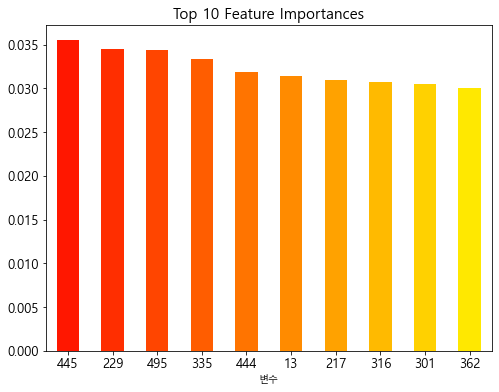

In [53]:
coef = pd.DataFrame(lr_estimator.coef_, columns=x_train_lr_select.columns)
coef_sort = coef.iloc[0,].sort_values(ascending=False)[:10]

colors = sns.color_palette('autumn', 10)
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances',size=15)
coef_sort.plot.bar(color=colors)
plt.xlabel('변수')
plt.xticks(rotation=0,size=13)
plt.yticks(size=13)
plt.show()

# [단계 6] 모델 평가

In [281]:
%%time

rf = RandomForestClassifier(n_estimators=2000,max_depth=10, min_samples_leaf=4, random_state=0)
rf.fit(x_train_scaled, y_train)


lgbm = LGBMClassifier(objective='binary',learning_rate=0.05, max_depth=10, n_estimators=2000, reg_lambda=1,random_state=0)
lgbm.fit(x_train_scaled, y_train)

xgb = XGBClassifier(eval_metric='error', learning_rate=0.05, max_depth=10, n_estimators=2000, objective='binary:logistic',random_state=0)
xgb.fit(x_train_scaled, y_train)

logic = LogisticRegression(C=0.1, penalty='l2', tol=0.0001, random_state=0)
logic.fit(x_train_scaled,y_train)

Wall time: 9min 39s


LogisticRegression(C=0.1, random_state=0)

In [217]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix 


print(y_test.value_counts()) # y_test 분포

500
0.0    681
1.0    639
dtype: int64


Random forest 시험용 데이터 세트 정확도:0.758


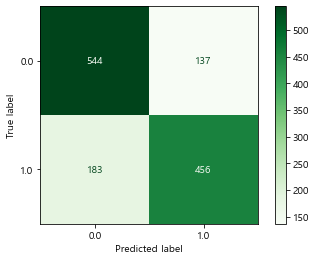

In [271]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

rf_pred = rf.predict(x_test_scaled) #랜덤포레스트
print('Random forest 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, rf_pred)))

plot = plot_confusion_matrix(rf, # 분류 모델
                             x_test_scaled, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             #display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.get_cmap('Greens'), # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
#plot.ax_.set_title('Confusion Matrix')

LGBM 시험용 데이터 세트 정확도:0.820


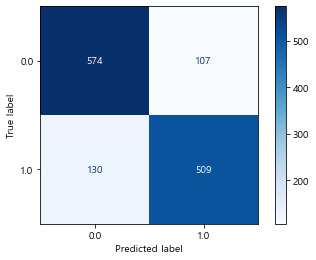

In [272]:
lg_pred = lgbm.predict(x_test_scaled) #lgbm
print('LGBM 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, lg_pred)))

plot = plot_confusion_matrix(lgbm, # 분류 모델
                             x_test_scaled, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             #display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.get_cmap('Blues'), # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
#plot.ax_.set_title('Confusion Matrix')

XGBoost 시험용 데이터 세트 정확도:0.819


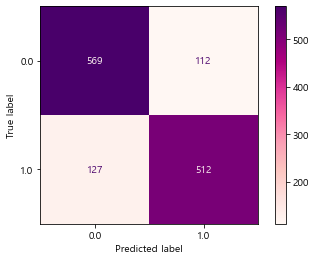

In [282]:
xgb_pred = xgb.predict(x_test_scaled) #xgb
print('XGBoost 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, xgb_pred)))

plot = plot_confusion_matrix(xgb, # 분류 모델
                             x_test_scaled, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             #display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.get_cmap('RdPu'), # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
#plot.ax_.set_title('Confusion Matrix')

Logistic Regression 시험용 데이터 세트 정확도:0.485


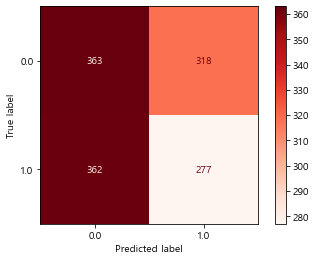

In [173]:
logic_pred = logic.predict(x_test_scaled) #로지스틱 
print('Logistic Regression 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, logic_pred)))

plot = plot_confusion_matrix(logic, # 분류 모델
                             x_test_scaled, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             #display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.get_cmap('Reds'), # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
#plot.ax_.set_title('Confusion Matrix')

In [283]:
print('Random forest 정밀도:{:.3f}'.format(precision_score (y_test, rf_pred, average='binary')))  
print('Random forest 재현율:{:.3f}'.format(recall_score(y_test, rf_pred, average='binary')))
print('Random forest f1-measure:{:.3f}'.format(f1_score(y_test, rf_pred, average='binary')))

print('\nLGBM 정밀도:{:.3f}'.format(precision_score (y_test, lg_pred, average='binary')))  
print('LGBM 재현율:{:.3f}'.format(recall_score(y_test, lg_pred, average='binary')))
print('LGBM f1-measure:{:.3f}'.format(f1_score(y_test, lg_pred, average='binary')))

print('\nXGBoost 정밀도:{:.3f}'.format(precision_score (y_test, xgb_pred, average='binary')))  
print('XGBoost 재현율:{:.3f}'.format(recall_score(y_test, xgb_pred, average='binary')))
print('XGBoost f1-measure:{:.3f}'.format(f1_score(y_test, xgb_pred, average='binary')))

print('\nLogistic Regression 정밀도:{:.3f}'.format(precision_score (y_test, logic_pred, average='binary'))) 
print('Logistic Regression 재현율:{:.3f}'.format(recall_score(y_test, logic_pred, average='binary')))
print('Logistic Regression f1-measure:{:.3f}'.format(f1_score(y_test, logic_pred, average='binary')))

Random forest 정밀도:0.769
Random forest 재현율:0.714
Random forest f1-measure:0.740

LGBM 정밀도:0.826
LGBM 재현율:0.797
LGBM f1-measure:0.811

XGBoost 정밀도:0.821
XGBoost 재현율:0.801
XGBoost f1-measure:0.811

Logistic Regression 정밀도:0.466
Logistic Regression 재현율:0.433
Logistic Regression f1-measure:0.449


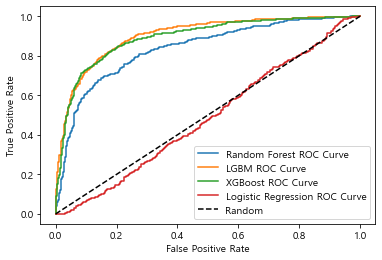

In [284]:
from sklearn.metrics import roc_auc_score, roc_curve

#print(tree.predict_proba(X_test))


fpr_rf, tpr_rf, cutoff_rf = roc_curve(y_test, rf.predict_proba(x_test_scaled)[:, 1])  #랜덤포레스트 
fpr_lg, tpr_lg, cutoff_lg = roc_curve(y_test, lgbm.predict_proba(x_test_scaled)[:, 1])  #lgbm
fpr_xgb, tpr_xgb, cutoff_xgb = roc_curve(y_test, xgb.predict_proba(x_test_scaled)[:, 1])  #xgb
fpr_logic, tpr_logic, cutoff_logic = roc_curve(y_test, logic.predict_proba(x_test_scaled)[:, 1])  #로지스틱


plt.plot(fpr_rf, tpr_rf, label="Random Forest ROC Curve")
plt.plot(fpr_lg, tpr_lg, label="LGBM ROC Curve")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost ROC Curve")
plt.plot(fpr_logic, tpr_logic, label="Logistic Regression ROC Curve")
plt.plot([0,1], [0, 1], "k--", label ="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc=4)
plt.show() 

In [285]:
auc_rf = roc_auc_score(y_test, rf.predict_proba(x_test_scaled)[:, 1]) #랜덤포레스트 
auc_lg = roc_auc_score(y_test, lgbm.predict_proba(x_test_scaled)[:, 1]) #lgbm
auc_xgb = roc_auc_score(y_test, xgb.predict_proba(x_test_scaled)[:, 1]) #xgb
auc_logic = roc_auc_score(y_test, logic.predict_proba(x_test_scaled)[:, 1]) #로지스틱


print("Random Forest의 AUC: {:.3f}".format(auc_rf))  ## AUC 면적이 가장 큰 모델
print("LGBM의 AUC: {:.3f}".format(auc_lg)) 
print("XGBoost의 AUC: {:.3f}".format(auc_xgb))
print("Logistic Regression의 AUC: {:.3f}".format(auc_logic))

Random Forest의 AUC: 0.836
LGBM의 AUC: 0.902
XGBoost의 AUC: 0.892
Logistic Regression의 AUC: 0.485
